In [1]:
# pennylane
import pennylane as qml
from pennylane import numpy as np

# dataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# optimization
import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
from skimage.transform import resize



# Load MNIST-like dataset (digits 0 and 1 only)

In [2]:
digits = load_digits()
X_full = digits.images  # shape (n_samples, 8, 8)
y_full = digits.target
# Filter only digits 0 and 1
mask = (y_full == 0) | (y_full == 1)
X_img = X_full[mask]
y = y_full[mask]
print("dataset size: ",len(y))

dataset size:  360


# Downscale images from 8x8 → 4x4 (flatten to 16 features)

In [3]:
X_small = np.array([resize(img, (4, 4), mode='reflect') for img in X_img])
X_flat = X_small.reshape((X_small.shape[0], -1)) / X_small.max()

# Visualize samples (original and downscaled)

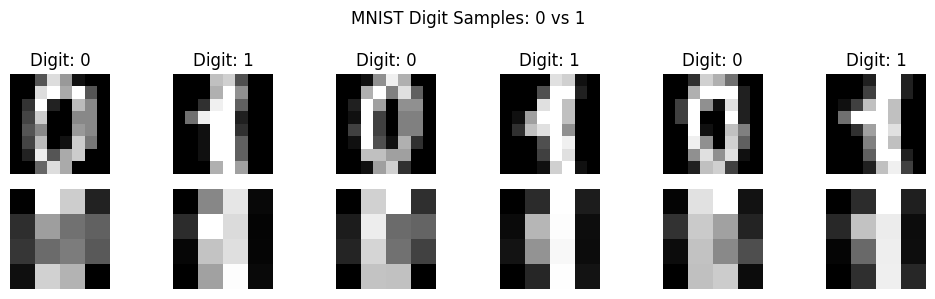

In [4]:
fig, axes = plt.subplots(2, 6, figsize=(10, 3))
for i in range(6):
    axes[0, i].imshow(X_img[i], cmap='gray')
    axes[0, i].set_title(f"Digit: {y[i]}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(X_small[i], cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel("Original")
axes[1, 0].set_ylabel("4×4 Downscaled")
plt.suptitle("MNIST Digit Samples: 0 vs 1")
plt.tight_layout()
plt.show()

# Train-test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Set up quantum device

In [7]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

# Define Encoding and Ansatz

In [8]:
# Encoding (dense angle)
def encoding_circuit(x):
    for i in range(n_qubits):
        qml.RY(x[4*i], wires=i)
        qml.RX(x[4*i+1], wires=i)
        qml.RZ(x[4*i+2], wires=i)
        qml.RY(x[4*i+3], wires=i)

# Ansatz
def ansatz_circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=range(n_qubits))

# whole circuit
@qml.qnode(dev, interface="jax")
def circuit(x, params):
    encoding_circuit(x) # encoding
    ansatz_circuit(params) # ansatz
    return qml.expval(qml.PauliZ(0)) # measure first qubit: output is between -1 and 1

# Draw the circuit

Full circuit with string parameters:


"0: ──RY(x0)───RX(x1)───RZ(x2)───RY(x3)──╭StronglyEntanglingLayers(M0)─┤  <Z>\n1: ──RY(x4)───RX(x5)───RZ(x6)───RY(x7)──├StronglyEntanglingLayers(M0)─┤     \n2: ──RY(x8)───RX(x9)───RZ(x10)──RY(x11)─├StronglyEntanglingLayers(M0)─┤     \n3: ──RY(x12)──RX(x13)──RZ(x14)──RY(x15)─╰StronglyEntanglingLayers(M0)─┤     \n\nM0 = \n[[['θ000' 'θ001' 'θ002']\n  ['θ010' 'θ011' 'θ012']\n  ['θ020' 'θ021' 'θ022']\n  ['θ030' 'θ031' 'θ032']]\n\n [['θ100' 'θ101' 'θ102']\n  ['θ110' 'θ111' 'θ112']\n  ['θ120' 'θ121' 'θ122']\n  ['θ130' 'θ131' 'θ132']]\n\n [['θ200' 'θ201' 'θ202']\n  ['θ210' 'θ211' 'θ212']\n  ['θ220' 'θ221' 'θ222']\n  ['θ230' 'θ231' 'θ232']]]"

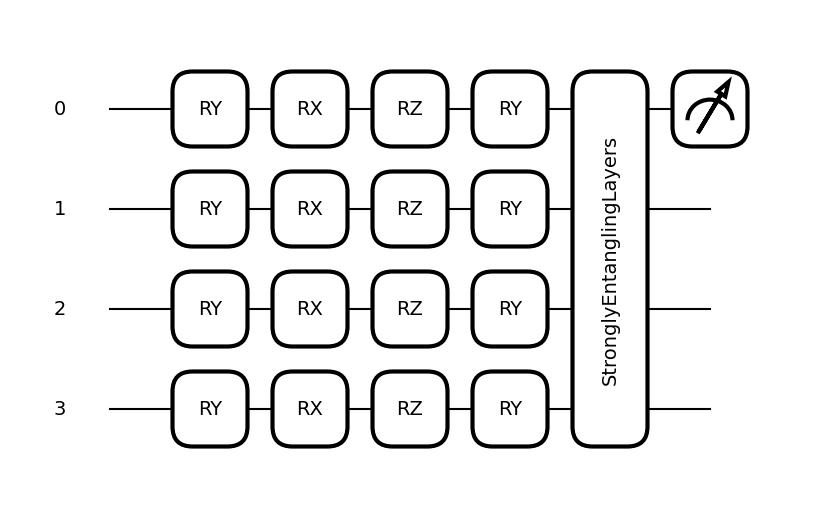

In [9]:
# Input encoding: flat list of strings "x0", ..., "x15"
x_str = [f"x{i}" for i in range(4 * n_qubits)]

# Parameter array (3 layers × n_qubits × 3 angles per qubit)
params_str = [[[f"θ{i}{j}{k}" for k in range(3)]
               for j in range(n_qubits)] for i in range(3)]


# Draw with symbolic values
print("Full circuit with string parameters:")
qml.draw_mpl(circuit)(x_str, params_str)
qml.draw(circuit)(x_str, params_str)

# Define cost function, parameters and optimizer

In [10]:
# Cost function (mean squared error)
def cost(params, x, y):
    preds = jax.vmap(lambda xi: circuit(xi, params))(x)
    labels = 1 - 2 * y  # map {0,1} → {+1, -1}
    return jnp.mean((preds - labels) ** 2)

# JIT the cost
cost = jax.jit(cost)

In [11]:
# Initialize parameters
key = jax.random.PRNGKey(0)
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
params = 0.01 * jax.random.normal(key, shape)

# Prepare data
X_train_jax = jnp.array(X_train)
y_train_jax = jnp.array(y_train)

In [12]:
# Optimizer setup
optimizer = optax.adam(learning_rate=0.2)
opt_state = optimizer.init(params)

# Run Training loop

In [13]:
@jax.jit
def step(params, opt_state, x, y):
    loss, grads = jax.value_and_grad(cost)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

# Training loop
for i in range(100):
    params, opt_state, loss = step(params, opt_state, X_train_jax, y_train_jax)
    if i % 5 == 0:
        print(f"Step {i}: loss = {loss:.4f}")

Step 0: loss = 1.3225
Step 5: loss = 0.9976
Step 10: loss = 0.9739
Step 15: loss = 0.8645
Step 20: loss = 0.7976
Step 25: loss = 0.7849
Step 30: loss = 0.7764
Step 35: loss = 0.7688
Step 40: loss = 0.7628
Step 45: loss = 0.7559
Step 50: loss = 0.7580
Step 55: loss = 0.7554
Step 60: loss = 0.7551
Step 65: loss = 0.7551
Step 70: loss = 0.7547
Step 75: loss = 0.7546
Step 80: loss = 0.7545
Step 85: loss = 0.7544
Step 90: loss = 0.7544
Step 95: loss = 0.7544


In [14]:
# --- Predict on train and test set ---

X_train_jax = jnp.array(X_train)  
y_train_jax = jnp.array(y_train)

X_test_jax = jnp.array(X_test)  
y_test_jax = jnp.array(y_test)

@jax.jit
def predict(x, params):
    return jax.vmap(lambda xi: circuit(xi, params))(x)    

# Run predictions
predictions_train = predict(X_train_jax, params)
predicted_labels_train = (predictions_train < 0).astype(int)  # map from [-1,+1] to 0/1
accuracy_train = jnp.mean(predicted_labels_train == y_train_jax)

predictions = predict(X_test_jax, params)
predicted_labels = (predictions < 0).astype(int)  # map from [-1,+1] to 0/1
accuracy = jnp.mean(predicted_labels == y_test_jax)

print(f"\nTrain Accuracy: {accuracy_train:.2%}")
print(f"\nTest Accuracy: {accuracy:.2%}")




Train Accuracy: 88.89%

Test Accuracy: 88.89%
